In [1]:
# additional functions to handle the data
from polepos_funcs import load_transmission_data_csv, plot_trcs, plot_search_results, delete_nan_cs_rows, search_peaks
import pandas as pd
import json

import numpy as np
from ATARI import PiTFAll as pf

In [2]:
%matplotlib widget

### TODO
- fix input dataframe
    - more robust handling of indices
    - don't require theoretical cross sections, make this an option if you want to plot. Input should be minimal, syndat experimental transmission and tof values only, add logic to be able to hand the rest.
- Make the code more robust for outlier cases, i.e., in the performance test I ran polepos_funcs threw error at line 230 when peaks_df_all was empty
- Write suggested parameters to hdf5 (maybe) - ideally PolePosition will be integrated into the fitting routines and we won't want to write anything to the performance_test.hdf5 other than the final estimate. However, for now, it might be useful to write an initial parameter guess file into the perf_test.hdf5[sample_{i}/init_guess_par]


In [3]:
import os

# test_data = os.path.realpath('../../Fitting/fitting_lite/syndat_data_SLBW.hdf5')
test_data = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/perf_test_staticwindow_poleposition.hdf5'

i = 28

# read pw and order 
test = pd.read_hdf(test_data, f'sample_{i}/exp_pw')
n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)
test['exp_cs'] = np.log(test['exp_trans']) / (-n)
test['theo_cs'] = np.log(test['theo_trans']) / (-n)
test.sort_values('E', inplace=True)
test.reset_index(drop=False,inplace=True)


test_par = pd.read_hdf(test_data, f'sample_{i}/theo_par')

# from matplotlib.pyplot import *
# # figure()
# # plot(test.E, test.exp_cs, '.')
# # plot(test.E, np.log(test['theo_trans']) / (-n))
test

,index,E,theo_trans,exp_trans,exp_cs,theo_cs
0,206,500.181348,0.785913,0.791120,3.488451,3.586774
1,205,500.406576,0.785947,0.778984,3.718622,3.586128
2,204,500.631957,0.785979,0.685206,5.628386,3.585529
3,203,500.857489,0.785991,0.807969,3.174695,3.585288
4,202,501.083174,0.785894,0.767288,3.943847,3.587128
...,...,...,...,...,...,...
202,4,548.963011,0.780407,0.812213,3.096700,3.691442
203,3,549.221983,0.780467,0.798245,3.354965,3.690296
204,2,549.481139,0.780525,0.632142,6.828484,3.689196
205,1,549.740478,0.780580,0.662060,6.139987,3.688139


In [4]:
# # input data - transmission dataframe - syndat output and calculating the cross section values

# tr_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_transmission_4980.csv'
# n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)

# transm_df = load_transmission_data_csv(tr_filename, n=n)

# transm_df

transm_df = test

In [5]:
# deleting all points with the negative transmission
transm_nonzero = delete_nan_cs_rows(transm_df)
transm_nonzero

Count in initial: 207 
Count in cleaned 207


,row_num,E,theo_trans,exp_trans,exp_cs,theo_cs
0,0,500.181348,0.785913,0.791120,3.488451,3.586774
1,1,500.406576,0.785947,0.778984,3.718622,3.586128
2,2,500.631957,0.785979,0.685206,5.628386,3.585529
3,3,500.857489,0.785991,0.807969,3.174695,3.585288
4,4,501.083174,0.785894,0.767288,3.943847,3.587128
...,...,...,...,...,...,...
202,202,548.963011,0.780407,0.812213,3.096700,3.691442
203,203,549.221983,0.780467,0.798245,3.354965,3.690296
204,204,549.481139,0.780525,0.632142,6.828484,3.689196
205,205,549.740478,0.780580,0.662060,6.139987,3.688139


In [6]:
# # loading ladder
# ladder_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_ladder.csv'

# ladder_df = pd.read_csv(ladder_filename, index_col=0)

# #modifying the ladder using json for correct lists in data lwave
# test = ladder_df.lwave.apply(json.loads)
# ladder_df['lwave'] = test

# ladder_df

In [7]:
ladder_df = test_par

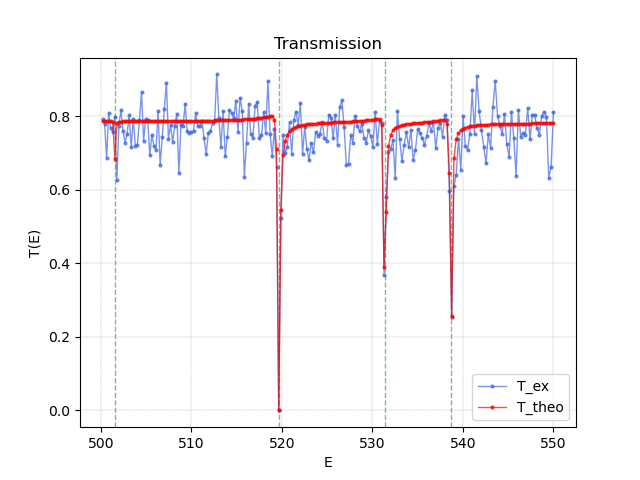

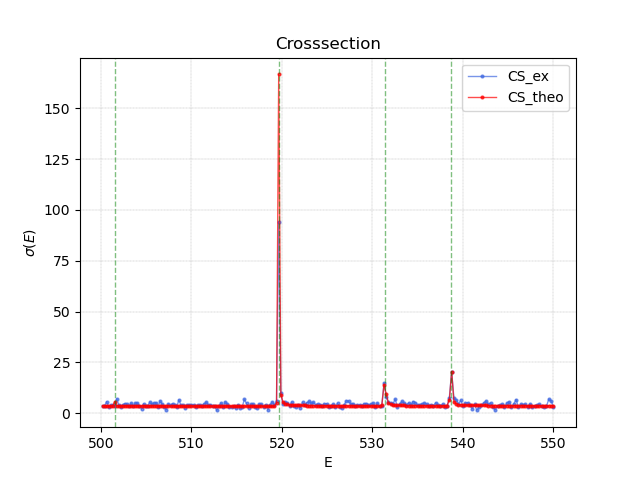

In [8]:
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy()],
    [transm_df['exp_trans'].to_numpy(), transm_df['theo_trans'].to_numpy()],
    'Transmission',
    ['T_ex', 'T_theo'],
    'E',
    'T(E)',
    ladder_df
)

# the same for cross-section values and adding the "clear values"
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy(), ],
    [transm_df['exp_cs'].to_numpy(), transm_df['theo_cs'].to_numpy()],
    'Crosssection',
    ['CS_ex', 'CS_theo', 'CS_ex_woNANS'],
    'E',
    '$\sigma(E)$',
    ladder_df
)

In [9]:
# using the find_all procedure to get all the peaks of cross-sections

# parameters of polepos
polepos_hps = {'search_params' : {'part_of_variance_filter': 0.2,
                                  'base_of_peak': 0.5, 
                                 'min_width': 0.01,
                                 'min_height': 0.01,
                                 'prominence': 0.01
                                 }, 

                 'reduce_params' : {'param_cutoff_by_name': 'peak_sq_divE',
                                    'cutoff_threshold': 0.03
                                    }
}

pulses_sel_df, pulses_all_df  = search_peaks(transm_nonzero,                    
                 search_params = polepos_hps['search_params'],           
                 reduce_params = polepos_hps['reduce_params']
)

Initial search gives: 28 peaks
Selected 16 peaks from 28


In [10]:
# actual number of resonances in a current ladder

print(f'We have in a actual ladder: {ladder_df.shape[0]}')

We have in a actual ladder: 4


In [12]:
# sorting result by weighted square
# pulses_sel_df.sort_values(by=['peak_sq_divE'], ascending=False)
pulses_sel_df.nlargest(10, 'peak_sq_divE')#.peak_E

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
11,11,84,519.644317,82,86,4,18.284484,519.167804,520.121487,0.953683,33.562385,30.555802,5,32.007889,20.639265,21.641632,1.0
22,22,162,538.752468,160,165,5,7.152769,538.249438,539.508337,1.258900,10.822774,7.340010,6,13.624786,11.708047,9.300223,1.0
17,17,132,531.280355,130,135,5,6.144996,530.787751,532.020548,1.232798,8.325696,4.361398,6,10.263899,8.940780,7.252431,1.0
27,27,204,549.481139,203,206,3,4.763145,549.221983,550.000000,0.778017,5.014226,0.502163,4,3.901153,4.340384,5.578778,1.0
15,15,116,527.358623,114,118,4,4.514369,526.871462,527.846461,0.974999,5.142187,1.255635,5,5.013625,5.024769,5.153616,1.0
18,18,140,533.257646,139,142,3,4.807861,533.009881,533.753693,0.743812,4.883402,0.151084,4,3.632334,3.760834,5.056161,1.0
19,19,145,534.499063,144,147,3,4.779684,534.250433,534.996845,0.746411,4.904783,0.250198,4,3.660984,3.763133,5.041635,1.0
24,24,187,545.100308,186,188,2,4.476756,544.844245,545.356551,0.512306,4.483197,0.012881,3,2.296769,2.566592,5.009880,1.0
0,0,2,500.631957,1,3,2,4.079572,500.406576,500.857489,0.450913,4.184903,0.210661,3,1.887027,2.209962,4.901083,1.0
12,12,98,522.998357,95,102,7,4.311897,522.276906,523.962620,1.685714,5.093192,1.562590,8,8.585662,8.096199,4.802832,1.0


In [70]:
# pulses_all_df.sort_values(by=['peak_height'], ascending=True)

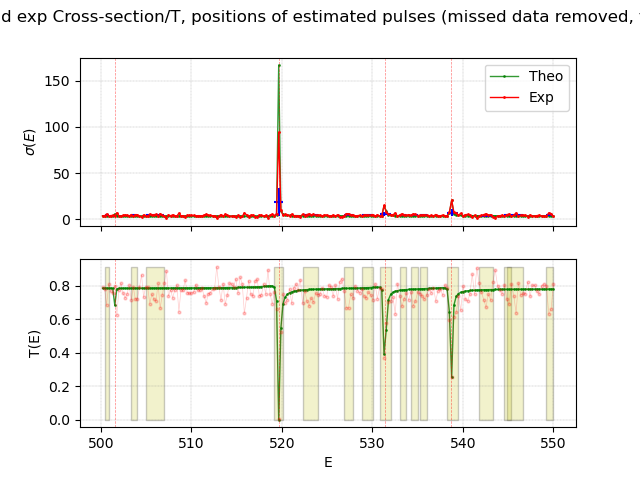

In [13]:
# plotting the results
plot_search_results(transm_df, ladder_df, pulses_sel_df)

In [72]:
pulses_sel_df[pulses_sel_df['peak_sq_divE']]

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
1,1,5,101.401466,4,6,2,4.046813,101.161052,101.642737,0.481685,4.655866,1.218106,3,2.242663,2.130417,4.422838,1.0
2,2,7,101.884871,6,8,2,3.966432,101.642737,102.127871,0.485134,3.982641,0.032417,3,1.932114,1.923806,3.965516,1.0
3,3,10,102.616487,9,11,2,4.031753,102.371742,102.862110,0.490369,4.240135,0.416764,3,2.079229,2.013301,4.105688,1.0
5,5,16,104.103559,15,17,2,3.805479,103.853478,104.354544,0.501067,4.524885,1.438811,3,2.267268,2.060977,4.113180,1.0
6,6,18,104.606439,17,19,2,3.868756,104.354544,104.859246,0.504702,4.133259,0.529006,3,2.086063,1.963225,3.889871,1.0
7,7,21,105.367618,20,22,2,3.815468,105.112971,105.623192,0.510221,4.062240,0.493543,3,2.072639,1.969493,3.860082,1.0
8,8,23,105.879696,22,24,2,3.878569,105.623192,106.137136,0.513944,4.001458,0.245778,3,2.056527,2.003212,3.897722,1.0
9,9,26,106.654841,25,27,2,3.763886,106.395516,106.915115,0.519599,3.920480,0.313187,3,2.037076,1.979505,3.809682,1.0
10,10,28,107.176343,27,29,2,3.705238,106.915115,107.438529,0.523414,4.256910,1.103344,3,2.228128,2.085689,3.984777,1.0
11,11,30,107.701679,29,32,3,3.835199,107.438529,108.230887,0.792358,3.930340,0.190282,4,3.114236,3.012209,3.801576,1.0


In [73]:
pulses_all_df

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
0,0,2,100.682783,0,3,3,3.710850,100.207897,100.921492,0.713595,3.752316,0.082933,4,2.677636,2.628166,3.682992,0.0
1,1,5,101.401466,4,6,2,4.046813,101.161052,101.642737,0.481685,4.655866,1.218106,3,2.242663,2.130417,4.422838,1.0
2,2,7,101.884871,6,8,2,3.966432,101.642737,102.127871,0.485134,3.982641,0.032417,3,1.932114,1.923806,3.965516,1.0
3,3,10,102.616487,9,11,2,4.031753,102.371742,102.862110,0.490369,4.240135,0.416764,3,2.079229,2.013301,4.105688,1.0
4,4,13,103.356011,12,15,3,3.651438,103.108617,103.853478,0.744861,3.889037,0.475198,4,2.896790,2.698935,3.623410,0.0
5,5,16,104.103559,15,17,2,3.805479,103.853478,104.354544,0.501067,4.524885,1.438811,3,2.267268,2.060977,4.113180,1.0
6,6,18,104.606439,17,19,2,3.868756,104.354544,104.859246,0.504702,4.133259,0.529006,3,2.086063,1.963225,3.889871,1.0
7,7,21,105.367618,20,22,2,3.815468,105.112971,105.623192,0.510221,4.062240,0.493543,3,2.072639,1.969493,3.860082,1.0
8,8,23,105.879696,22,24,2,3.878569,105.623192,106.137136,0.513944,4.001458,0.245778,3,2.056527,2.003212,3.897722,1.0
9,9,26,106.654841,25,27,2,3.763886,106.395516,106.915115,0.519599,3.920480,0.313187,3,2.037076,1.979505,3.809682,1.0
